**Importing Libraries**

In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np

from datetime import date
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Reading the dataset**

In [4]:
features = pd.read_csv('/content/drive/MyDrive/Xccelerate/02 ML Project/Datasets/features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,False
1,1,2010-02-12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,True
2,1,2010-02-19,39.93,2.51,NaN,NaN,NaN,NaN,NaN,211.29,8.11,False
3,1,2010-02-26,46.63,2.56,NaN,NaN,NaN,NaN,NaN,211.32,8.11,False
4,1,2010-03-05,46.50,2.62,NaN,NaN,NaN,NaN,NaN,211.35,8.11,False


In [5]:
stores = pd.read_csv('/content/drive/MyDrive/Xccelerate/02 ML Project/Datasets/stores.csv')
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
train = pd.read_csv('/content/drive/MyDrive/Xccelerate/02 ML Project/Datasets/train.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
# Combine 3 dataset into 1 for train data
data = train.merge(features, on=['Store', 'Date','IsHoliday'], how='inner').merge(stores, on=['Store'], how='inner')
# Add new column "Total_MarkDown"
data['Total_MarkDown'] = data['MarkDown1']+data['MarkDown2']+data['MarkDown3']+data['MarkDown4']+data['MarkDown5']
# Transform Date format and add new columns "Week", "Month", "Quarter", "Year"
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Quarter'] = data['Date'].dt.quarter
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.week
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Total_MarkDown,Year,Quarter,Month,Week
0,1,1,2010-02-05,24924.50,False,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,NaN,2010,1,2,5
1,1,2,2010-02-05,50605.27,False,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,NaN,2010,1,2,5
2,1,3,2010-02-05,13740.12,False,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,NaN,2010,1,2,5
3,1,4,2010-02-05,39954.04,False,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,NaN,2010,1,2,5
4,1,5,2010-02-05,32229.38,False,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315,NaN,2010,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.88,4018.91,58.08,100.00,211.94,858.33,192.31,8.67,B,118221,5247.26,2012,4,10,43
421566,45,94,2012-10-26,5203.31,False,58.85,3.88,4018.91,58.08,100.00,211.94,858.33,192.31,8.67,B,118221,5247.26,2012,4,10,43
421567,45,95,2012-10-26,56017.47,False,58.85,3.88,4018.91,58.08,100.00,211.94,858.33,192.31,8.67,B,118221,5247.26,2012,4,10,43
421568,45,97,2012-10-26,6817.48,False,58.85,3.88,4018.91,58.08,100.00,211.94,858.33,192.31,8.67,B,118221,5247.26,2012,4,10,43


In [8]:
#Check missing data
round(data.isnull().sum()/len(data)*100,2)

Store             0.00
Dept              0.00
Date              0.00
Weekly_Sales      0.00
IsHoliday         0.00
Temperature       0.00
Fuel_Price        0.00
MarkDown1        64.26
MarkDown2        73.61
MarkDown3        67.48
MarkDown4        67.98
MarkDown5        64.08
CPI               0.00
Unemployment      0.00
Type              0.00
Size              0.00
Total_MarkDown   76.98
Year              0.00
Quarter           0.00
Month             0.00
Week              0.00
dtype: float64

Text(0.5, 1.0, 'Correlation Matrix')

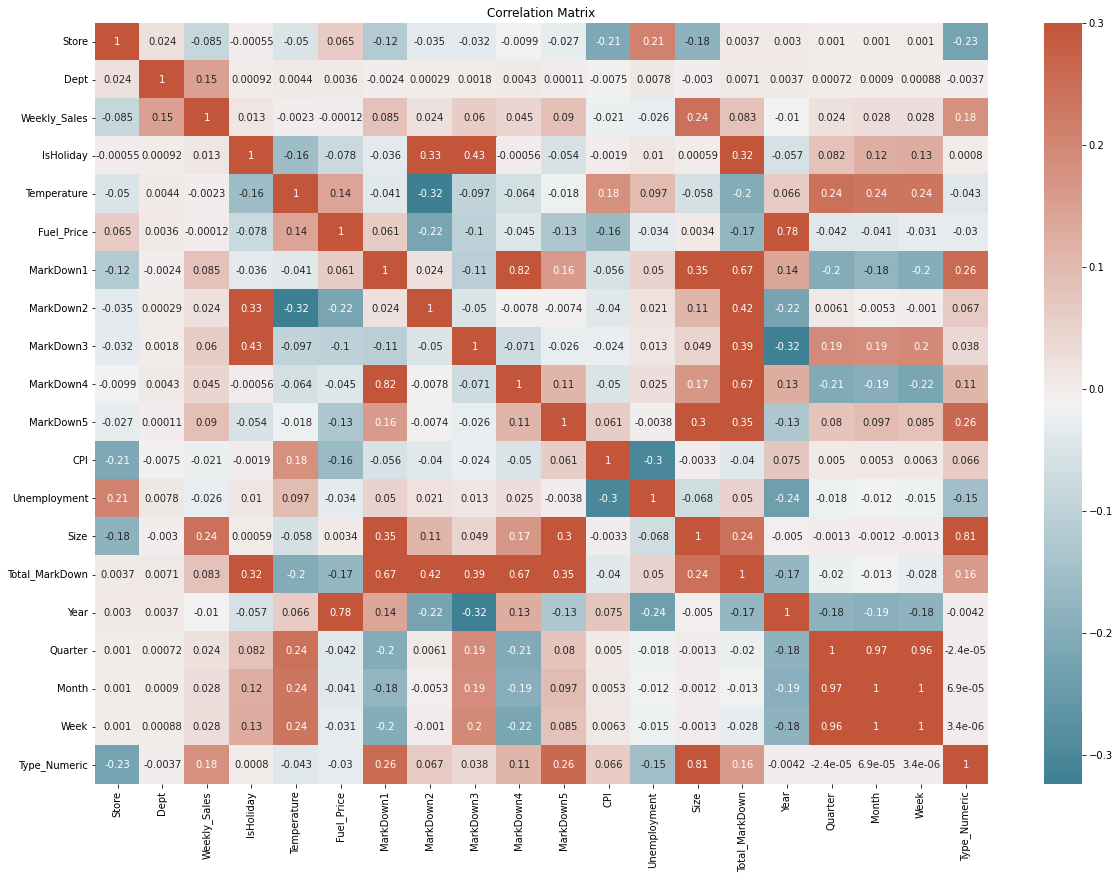

In [9]:
# To see which to keep which to remove
storetype_values = {'A':3, 'B':2, 'C':1}
data['Type_Numeric'] = data.Type.map(storetype_values)

plt.figure(figsize=(20,14))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(data.corr(), cmap=cmap, vmax=.3, annot=True)
plt.title("Correlation Matrix")

In [85]:
# Walmart Weekly Sales
weekly_sales = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
weekly_sales.head()

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


In [38]:
#Create dataframe of holidays with date
superbowl = pd.DataFrame({
  'Holiday': 'Superbowl',
  'Date': pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08']),
})
laborday = pd.DataFrame({
  'Holiday': 'Laborday',
  'Date': pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07','2013-09-06']),
})
thanksgiving = pd.DataFrame({
  'Holiday': 'Thanksgiving',
  'Date': pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23','2013-11-29']),
})
christmas = pd.DataFrame({
  'Holiday': 'Christmas',
  'Date': pd.to_datetime(['2010-12-31', '2011-12-30', '2012-12-28','2013-12-27']),
})
holidays = pd.concat((superbowl, laborday, thanksgiving,christmas))
holidays = holidays[['Date','Holiday']]
holidays.columns = ['ds','holiday']
holidays

,ds,holiday
0,2010-02-12,Superbowl
1,2011-02-11,Superbowl
2,2012-02-10,Superbowl
3,2013-02-08,Superbowl
0,2010-09-10,Laborday
1,2011-09-09,Laborday
2,2012-09-07,Laborday
3,2013-09-06,Laborday
0,2010-11-26,Thanksgiving
1,2011-11-25,Thanksgiving


### FB Prophet

In [58]:
#Prepare the training and testing set from weekly_sales dataset
print("Total no. of rows:",int(len(weekly_sales)))
print("Rows of 80%:",int(len(weekly_sales)*(80/100)))

Total no. of rows: 143
Rows of 80%: 114


In [59]:
#Take 80% as training data
weekly_sales_train = weekly_sales.iloc[:115,:]
weekly_sales_train.columns = ['ds','y']
weekly_sales_train

,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
110,2012-03-16,46901504.94
111,2012-03-23,44993794.45
112,2012-03-30,45272862.02
113,2012-04-06,53502315.87


In [60]:
#Take full dataset as testing data
weekly_sales_test = weekly_sales
weekly_sales_test.columns = ['ds','y']
weekly_sales_test

,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
138,2012-09-28,43734899.40
139,2012-10-05,47566639.31
140,2012-10-12,46128514.25
141,2012-10-19,45122410.57


In [116]:
# define the model
fbprophet = Prophet(holidays=holidays,yearly_seasonality=15)

# fit the model
fbprophet.fit(weekly_sales_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [117]:
# use the model to make a forecast & summarize the forecast
forecast = fbprophet.predict(weekly_sales_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,47512903.61,45537756.42,49483873.33
1,2010-02-12,49149603.57,46988674.74,51141098.08
2,2010-02-19,48742802.40,46724595.99,50689911.94
3,2010-02-26,44487937.02,42388556.04,46587082.58
4,2010-03-05,46268454.29,44320351.44,48275738.00


In [118]:
weekly_sales_forecast = forecast[['ds','yhat']]
weekly_sales_forecast.head()

,ds,yhat
0,2010-02-05,47512903.61
1,2010-02-12,49149603.57
2,2010-02-19,48742802.40
3,2010-02-26,44487937.02
4,2010-03-05,46268454.29


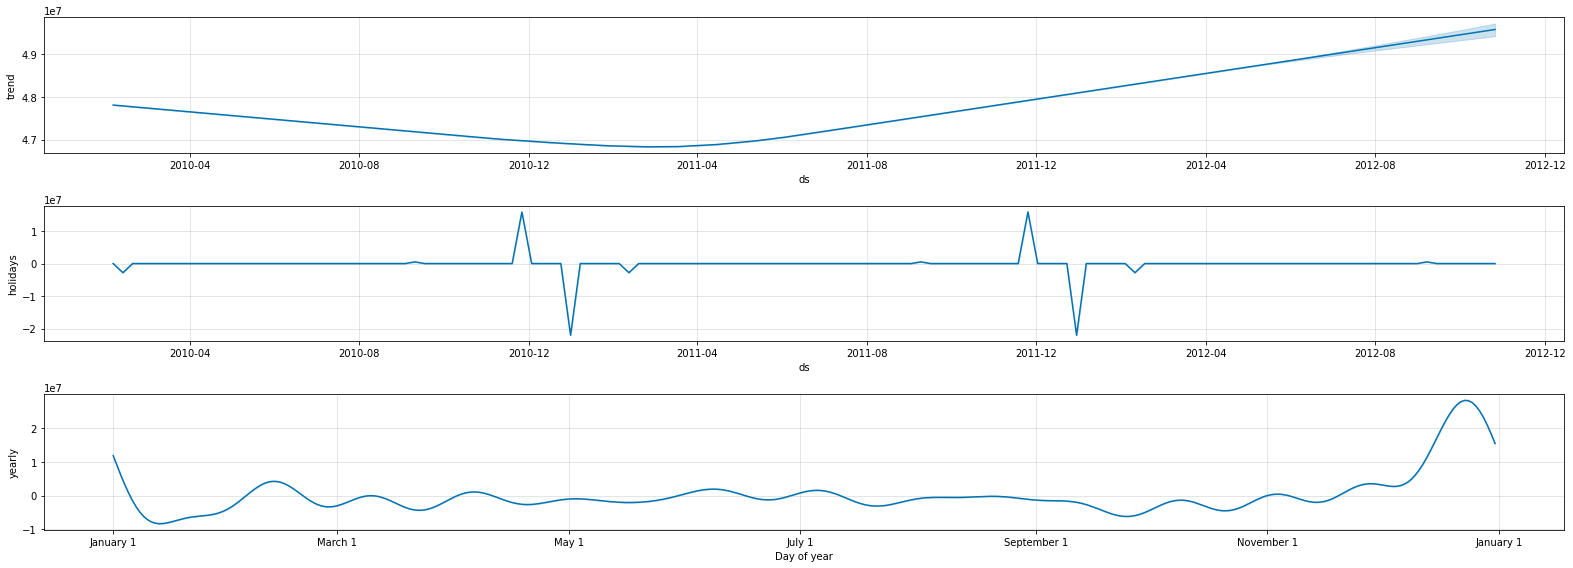

In [120]:
# plot forecast components
fbprophet.plot_components(forecast,figsize=(22,8))
plt.show()

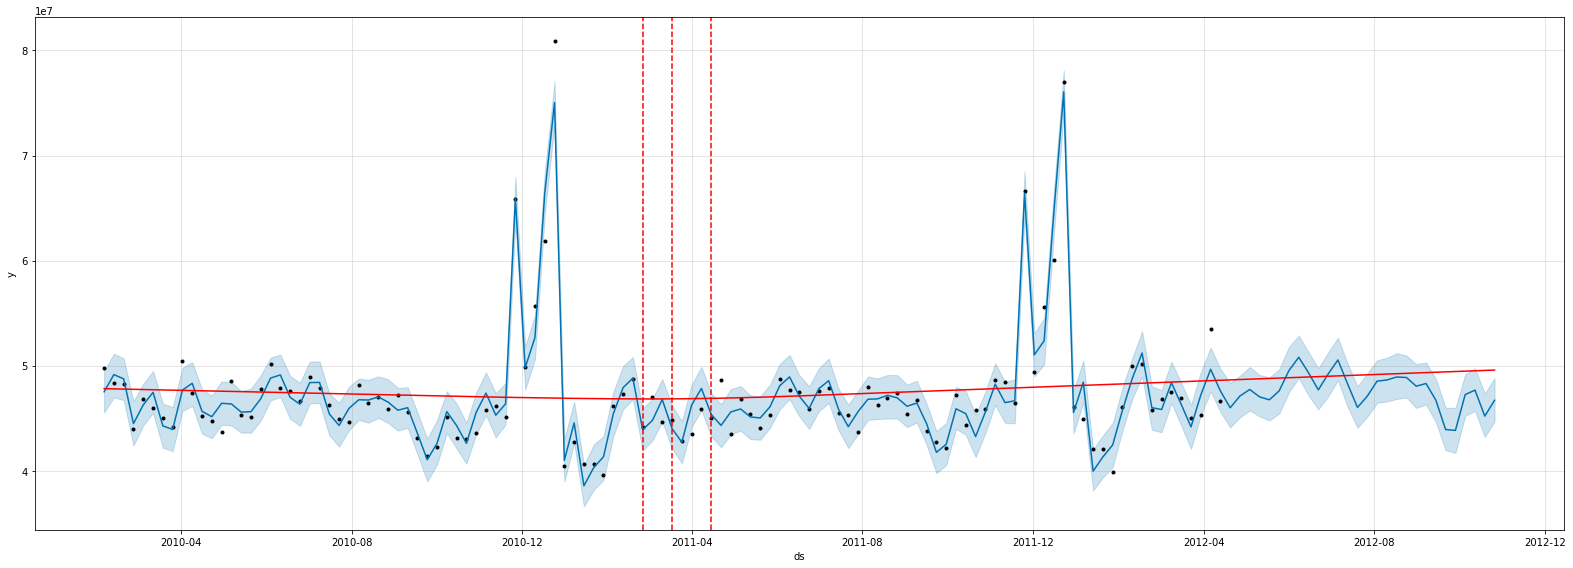

In [145]:
# Plot trend changepoints
from fbprophet.plot import add_changepoints_to_plot
plot1 = fbprophet.plot(forecast,figsize=(22,8))
a = add_changepoints_to_plot(plot1.gca(),fbprophet,forecast)

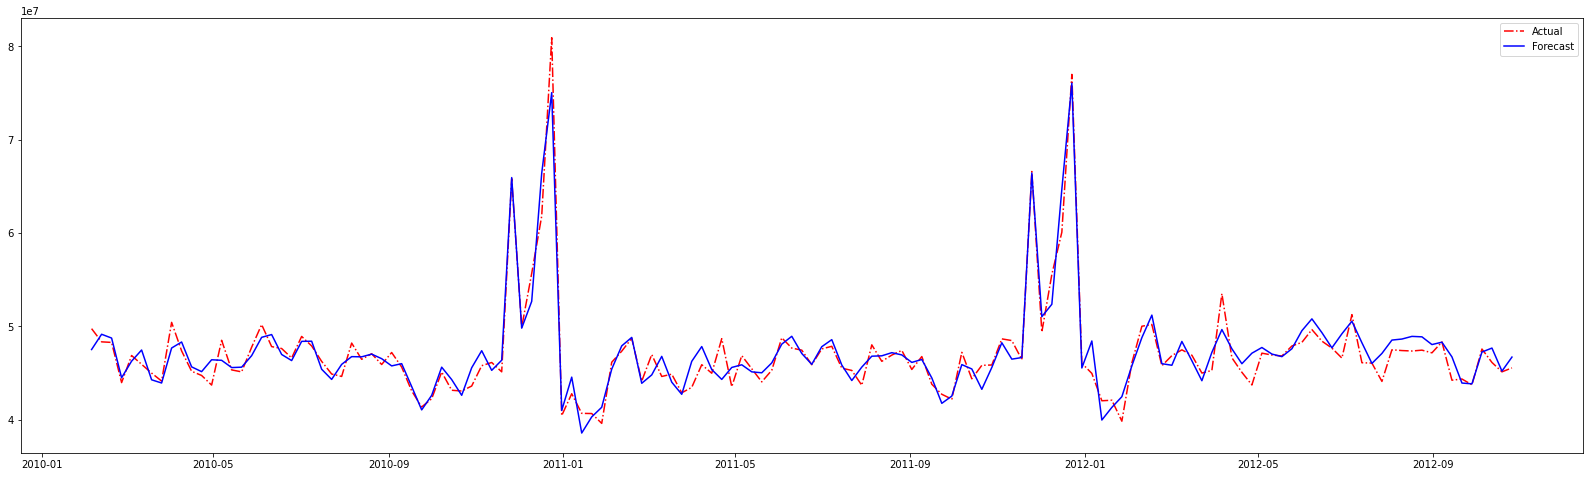

In [122]:
# plot actual & forecast
plt.figure(figsize=(28,8))
plt.plot(weekly_sales['Date'],weekly_sales['Weekly_Sales'],color='red',linestyle='-.',label='Actual')
plt.plot(forecast['ds'],forecast['yhat'],color='blue',label='Forecast')
plt.legend()
plt.show()

Cross Validation & Hyperparamter Tuning

Source: 
- https://jadsmkbdatalab.nl/forecasting-with-facebook-prophet-models-an-intro/
- https://facebook.github.io/prophet/docs/diagnostics.html


In [149]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(fbprophet, horizon = '90 days')
df_cv.tail()

INFO:fbprophet:Making 8 forecasts with cutoffs between 2011-03-05 00:00:00 and 2012-01-14 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
98,2012-03-16,45798970.41,43654436.75,47771292.50,46901504.94,2012-01-14
99,2012-03-23,43737027.30,41763003.23,45713537.51,44993794.45,2012-01-14
100,2012-03-30,46288401.32,44351464.53,48177632.08,45272862.02,2012-01-14
101,2012-04-06,48447931.40,46415472.31,50361352.25,53502315.87,2012-01-14
102,2012-04-13,46717925.54,44853193.95,48660555.28,46629261.41,2012-01-14


In [150]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,8016809746399.64,2831397.14,2338626.60,0.05,0.04,0.50
1,10 days,7981228567896.25,2825106.82,2312642.32,0.05,0.04,0.50
2,11 days,7548368157576.89,2747429.37,2188908.39,0.05,0.03,0.60
3,12 days,4042705504170.04,2010648.03,1741017.36,0.04,0.03,0.70
4,13 days,3286327711615.86,1812823.13,1587592.29,0.04,0.03,0.70


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: 

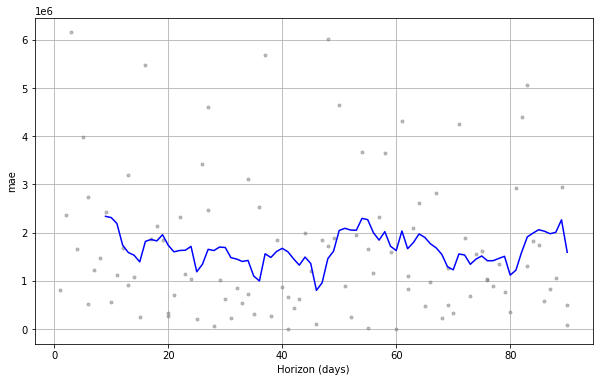

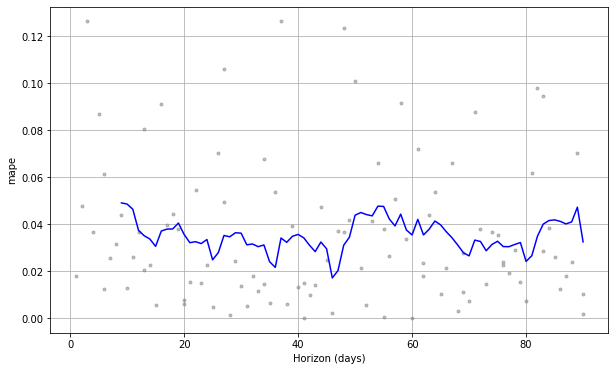

In [153]:
from fbprophet.plot import plot_cross_validation_metric
fig_mae = plot_cross_validation_metric(df_cv, metric='mae')
fig_mape = plot_cross_validation_metric(df_cv, metric='mape')

In [155]:
# Hyperparameters tuning

import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    fbprophet_new = Prophet(**params).fit(weekly_sales_train)  # Fit model with given params
    df_cv_new = cross_validation(fbprophet_new, horizon='90 days', parallel="processes")
    df_p_new = performance_metrics(df_cv_new, rolling_window=1)
    maes.append(df_p_new['mae'].values[0])
    mapes.append(df_p_new['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2011-03-05 00:00:00 and 2012-01-14 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f3be8bd1850>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2011-03-05 00:00:00 and 2012-01-14 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f3be7e73f10>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

In [158]:
# Print Hyperparamter tuning result
tuning_results.sort_values(['mae','mape'])

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
4,0.01,0.01,2454539.57,0.05
0,0.00,0.01,2493883.21,0.05
8,0.10,0.01,2550541.23,0.05
1,0.00,0.10,2679347.28,0.05
3,0.00,10.00,2692839.24,0.05
2,0.00,1.00,2718647.10,0.05
9,0.10,0.10,2751979.50,0.05
10,0.10,1.00,2756953.00,0.05
6,0.01,1.00,2757568.96,0.05
11,0.10,10.00,2765013.89,0.05


In [156]:
# Print best params
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


In [159]:
# define the new model with best params
fbprophet_v2 = Prophet(holidays=holidays,yearly_seasonality=15,changepoint_prior_scale=0.01, seasonality_prior_scale=0.01)

# fit the new model
fbprophet_v2.fit(weekly_sales_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [161]:
# use the new model to make a forecast & summarize the forecast
forecast_v2 = fbprophet_v2.predict(weekly_sales_test)
forecast_v2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,47121835.32,44758673.42,49586632.95
1,2010-02-12,48347853.29,45809803.45,50715049.75
2,2010-02-19,48126885.67,45690089.63,50501136.87
3,2010-02-26,44178024.97,41778080.46,46481855.95
4,2010-03-05,45984891.40,43641601.52,48483875.24


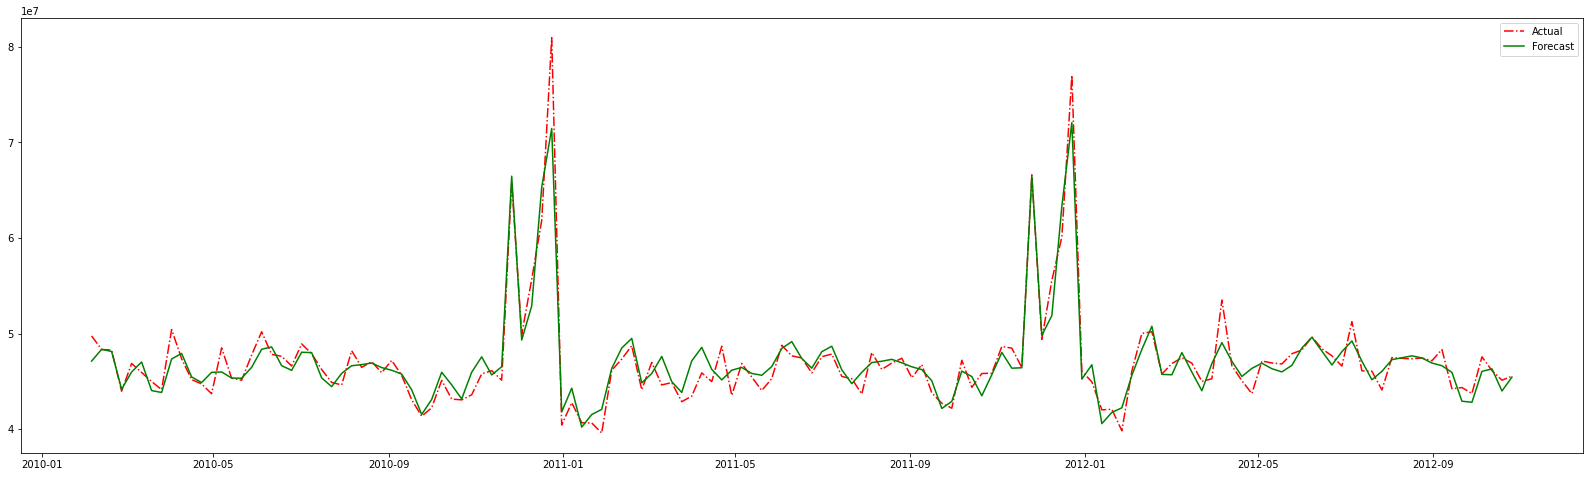

In [162]:
# plot actual & new forecast
plt.figure(figsize=(28,8))
plt.plot(weekly_sales['Date'],weekly_sales['Weekly_Sales'],color='red',linestyle='-.',label='Actual')
plt.plot(forecast_v2['ds'],forecast_v2['yhat'],color='green',label='Forecast')
plt.legend()
plt.show()